In [ ]:
# SETUP

In [9]:
from models import Market, Transactions, PIB, models_connection, models_keyspace
from cassandra.cqlengine import connection,management
from cassandra.cluster import Cluster

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics

"""
Scylla Manager
This class does the setup to use scylla. You must give the models that you want to be sync.
"""
class ScyllaManager():
    # Host to connect
    host_list = ['datadb']
    def __init__(self, models) -> None:
        # Do connection
        self.session = Cluster(self.host_list).connect()

        # Register connection
        self.register_session(models_connection)

        # It creates the specified keyspace, it can be anything, but my models export their respective keyspace and connection name
        self.create_keyspace(models_keyspace,[models_connection])
        
        #Sync models
        for Model in models:
            management.sync_table(Model)

    # Specifications for the context logic
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, tb):
        connection.unregister_connection(models_connection)
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        return True

    def close(self):
        connection.unregister_connection(models_connection)

    # Handler for registering the connection
    def register_session(self, connection_name):
        connection.register_connection(connection_name, session=self.session)
    
    # Handler for creating keyspace. It always create a SimpleStrategy keyspace with one node. Change it at will and your own risk.
    def create_keyspace(self, name, connections):
        management.create_keyspace_simple(name,1,True,connections)

In [ ]:
# Create scylla_manager() (There will be a warning I don't really know how to get rid of it but it doesn't affect the script)

In [3]:
scylla_manager = ScyllaManager(models=[Market, Transactions, PIB])

/home/sergiopereo/ITAM/NoSQL/gmw/data_processor/dataenv/lib/python3.10/site-packages/cassandra/cqlengine/management.py:553: UserWarning: CQLENG_ALLOW_SCHEMA_MANAGEMENT environment variable is not set. Future versions of this package will require this variable to enable management functions.
  warnings.warn(msg)


In [ ]:
# How is the PIB doing inside the economy?

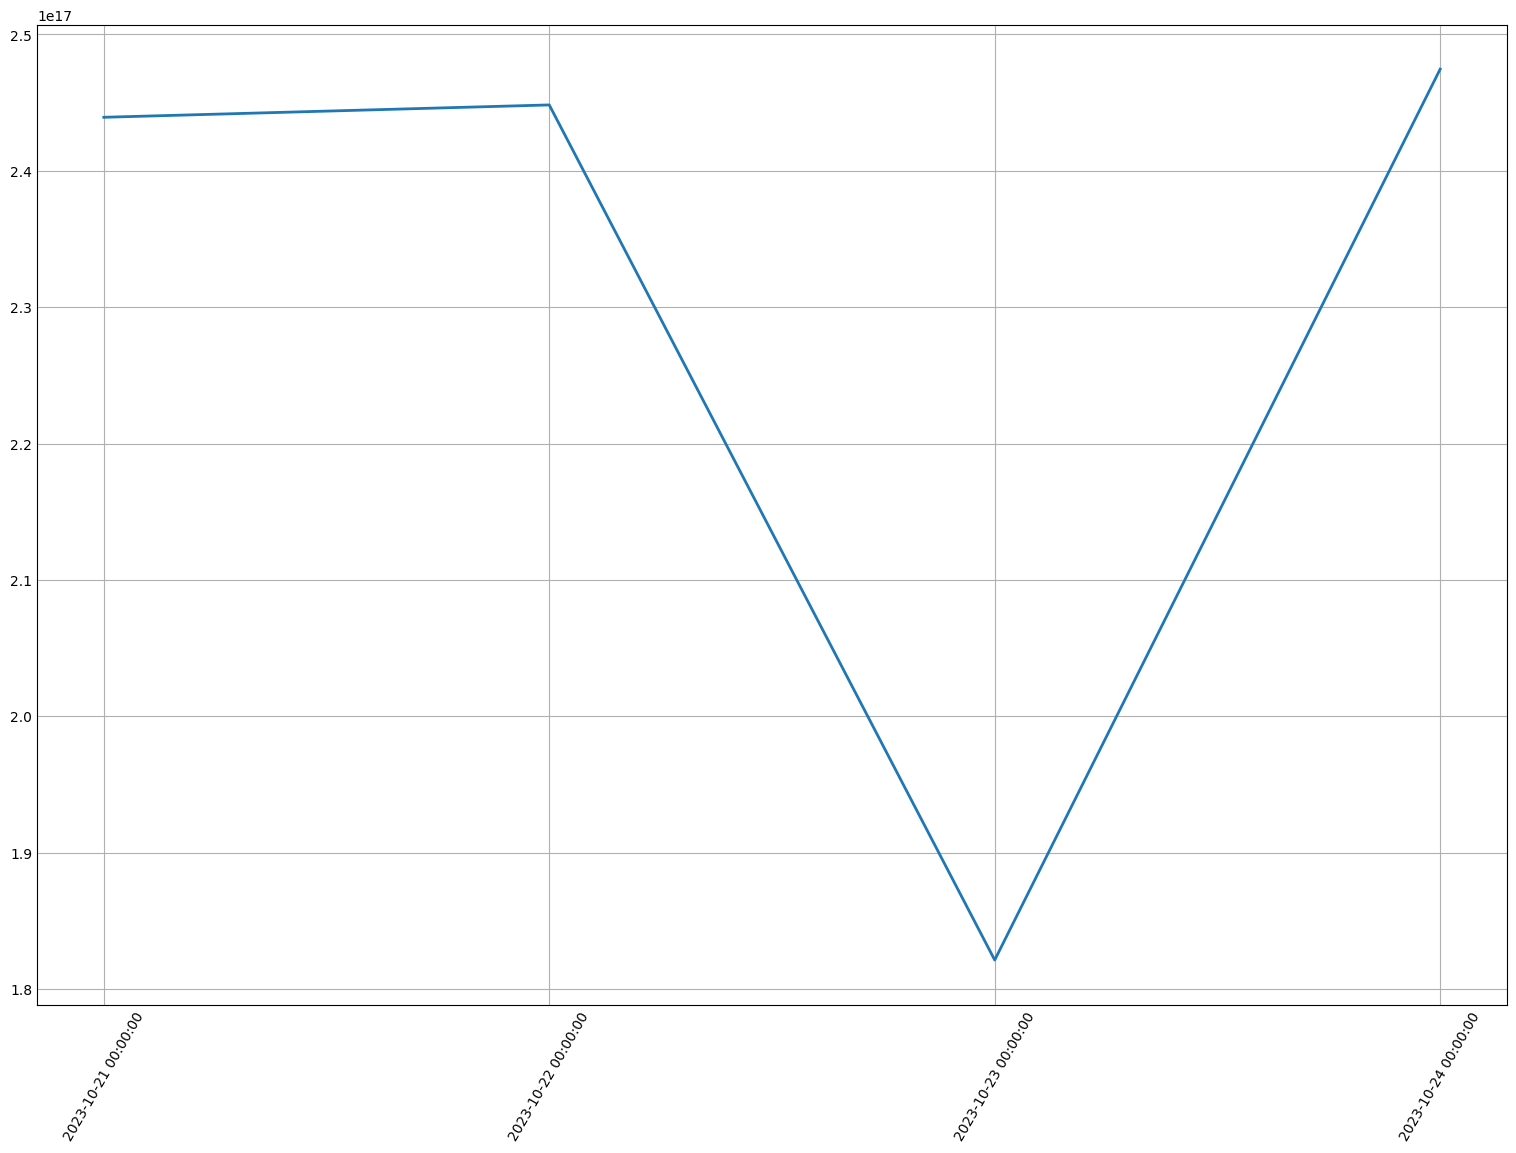

In [4]:
plt.style.use('_mpl-gallery')
# make data
pib = PIB.objects().all()
x = [str(datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)) for p in pib]
y = [p.value for p in pib]
# plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(x, y, linewidth=2.0)
plt.xticks(rotation=60)
plt.show()
    

In [ ]:
# How many transactions are being made of an specific items list a day? Which type of transaction?

In [5]:
subset_items = [24295, 24358, 24351, 24357, 24289, 24300, 24283, 24277, 24294, 24341, 24350, 24356, 24288, 24299, 24282, 19721]
transactions = Transactions.objects.filter(item_id__in=subset_items)
transactions_sells = [t for t in transactions if t.trans_type=="sells"]
transactions_buys = [t for t in transactions if t.trans_type=="buys"]
print("Mixed transactions", len(transactions))
print("Sells transactions", len(transactions_sells))
print("Buys transactions", len(transactions_buys))


Mixed transactions 9090
Sells transactions 4118
Buys transactions 4972


In [ ]:
# How can I compare the demand of these items with respect of the entire demand of objects?

In [11]:
pib = PIB.objects().all()
transactions_lookup = scylla_manager.session.prepare("select sum(price),sum(quantity) from gmw_dw.transactions where item_id in ? and date>=? and date<?")
percentages = []
for p in pib:
    initial=datetime.datetime(p.year, p.month, p.day, 0, 0, 0, 0)
    query_set = scylla_manager.session.execute(transactions_lookup, [subset_items, initial, initial+datetime.timedelta(1)])
    percentage_of_total = (query_set.one()['system.sum(price)']*query_set.one()['system.sum(quantity)'])/p.value
    percentages.append(percentage_of_total)
print("The percentage of the demand of this items is: ", statistics.mean(percentages))

The percentage of the demand of this items is:  2.2321391087459104e-05
